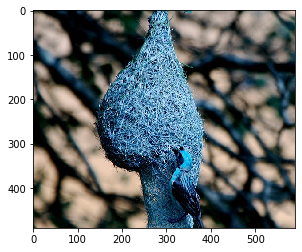

In [1]:
#import the necesary modules
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pandas as pd
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
from numpy  import array
from random import randrange
#load the image
img = cv2.imread('/mnt/ubuntu_disk/Ubuntu_drive/Nests/example_nest.jpeg')
plt.imshow(img)

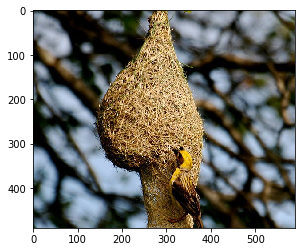

In [2]:
#opencv opens the image with the wrong colours channels
#this code corrects that
img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#plot the image
plt.imshow(img)

In [4]:
#load of themanually anotated polygons using VGG annotator
df= pd.read_csv("/mnt/ubuntu_disk/Ubuntu_drive/Nests/via_region_data.csv")
#print dataframe
df

,#filename,file_size,file_attributes,region_count,region_id,region_shape_attributes,region_attributes
0,example_nest.jpeg,76737,{},1,0,"{""name"":""polygon"",""all_points_x"":[274,266,229,...",{}


In [5]:
#print the cell with the polygon coordinates (of the region of interest)
print(df['region_shape_attributes'][0])

{"name":"polygon","all_points_x":[274,266,229,179,151,157,181,219,244,259,270,313,300,295,314,309,327,361,368,377,367,334,306,297,276],"all_points_y":[9,63,117,176,242,293,331,345,345,421,470,452,414,377,351,313,304,313,378,291,239,149,81,11,9]}


In [13]:
#function to convert the cell (string) to list of coordinates (x,y) in order to
#be easier to extract the coordinates later
def Convert(string): 
    li = list(string.split(",")) 
    return li 

In [14]:
#remove the text that is not needed and keep only the coordinates
coord=df["region_shape_attributes"][0].replace('{"name":"polygon","all_points_x":', "")
coord=coord.replace(',"all_points_y":', "")
coord=coord.replace(']', "")
coord=coord.replace('}', "")
#create a list for the xx coordinates and another for the yy coordinates
coordx=coord.split("[")[1]
coordx=Convert(coordx)
coordy=coord.split("[")[2]
coordy=Convert(coordy)

In [26]:
#create a final list with by merging the xx and yy lists
polycoordinates=[]
for i in range(len(coordy)):
    polycoordinates.append([coordx[i],coordy[i]])
#convert to array in order to extract the background later
polycoordinates = array(polycoordinates, np.int32)

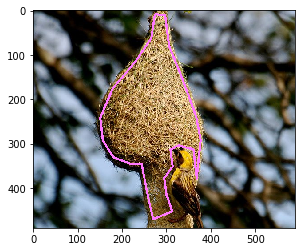

In [27]:
#plot the image with the delimited region of interest 
img_mod = cv2.polylines(img, [polycoordinates], True, (255,120,255),3)
plt.imshow(img_mod)

In [28]:
#Crop the bounding box of the polygon
rect = cv2.boundingRect(polycoordinates)
x,y,w,h = rect
croped = img[y:y+h, x:x+w].copy()
# create a mask corresponding to the area of the selected polygon
polycoordinates = polycoordinates - polycoordinates.min(axis=0)
mask = np.zeros(croped.shape[:2], np.uint8)
cv2.drawContours(mask, [polycoordinates], -1, (255, 255, 255), -1, cv2.LINE_AA)
#remove the background
dst = cv2.bitwise_and(croped, croped, mask=mask)

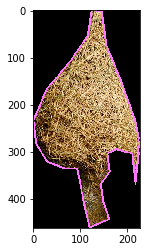

In [29]:
#plot the image
plt.imshow(dst)

In [30]:
#re-convert the polygon array to list again in order to
#use the functions from the shapely module. Which includes a function
#that allows to check if a point is inside a polygon, using functions "Point(x,y)"
#and "Polygon(list_of_coordinates)"
polygon_x=[]
for i in range(0,len(polycoordinates)):
    polygon_x.append((polycoordinates[i][0],polycoordinates[i][1]))

In [31]:
#convert to polygon object type of shapely module
poly_final=Polygon(polygon_x)

In [50]:
#make random squares
#keep the ones that are inside the picture only


#create a copy of the image for ilustration
dst_test=dst.copy()
#create a list to store the squares
squares=[]

#number of squares needed
num_squares=20

#loop until it reaches the number of squares needed
while len(squares)<num_squares:
    #randomly chose a x and a y coodinate
    x=randrange(0, dst_test.shape[0])
    y=randrange(0, dst_test.shape[1])
    #randomly chose the length of the edges of squares (in this case between 10 to 50)
    size=randrange(10, 50)
    #get all points inside the randomly determined square
    X, Y = np.mgrid[x:x+size, y:y+size]
    points=np.vstack((X.ravel(), Y.ravel()))
    #variable to note if all points are inside the polygon of interest
    all_true=1
    #loop through all points if any of the points is outside of the 
    #region of interest change "all_true" variable to 0
    for i in range(0, len(points[0])):
        if poly_final.contains((Point(points[0][i], points[1][i]))) == False:
            all_true=0
            break
    #only if all_true=1 include that square in the list
    if all_true==1:
        squares.append([(x,y),(x+size,y+size)])

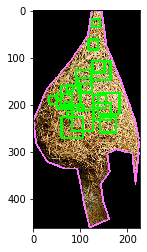

In [66]:
#for ilustration loop through all squares on the list and draw a rectange
#
from matplotlib.pyplot import figure
finaltest=dst_test.copy()
plt.figure()
for i in range(0, len(squares)):
    finaltest=cv2.rectangle(finaltest,squares[i][0], squares[i][1],(0,255,0),3)
    #figure(num=None, figsize=(8, 8), dpi=80, facecolor='w', edgecolor='k')
    cropped=dst_test[squares[i][0][0]:squares[i][0][0]+squares[i][1][0]-squares[i][0][0],squares[i][0][1]:squares[i][0][1]+squares[i][1][1]-squares[i][0][1] ]
imgplot = plt.imshow(finaltest)
plt.show(imgplot)

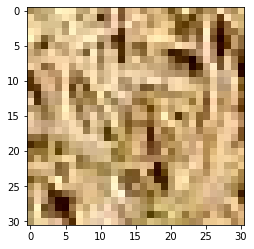

In [67]:
#plot the last square for ilustration
imgplot = plt.imshow(cropped)
plt.show(imgplot)

In [ ]:
#other things that can be add to the main loop:
#limit the number of square with a area above of below z
#distribute the squares evenly across the image
#limit the overlap between squares
#etc..